# Multi-Layer Perceptron


#### The following code contains an implementation of a multi-layer perceptron 3-class classifier from scratch, followed by a PyTorch implementation of the same

Import libraries.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Generate 2D data for the three classes.

In [2]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 0:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 0:
        y = 1
    else:
        y = 2
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,2] = 1

for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 0.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = -0.75 + 0.20 * np.random.normal()
    data.iloc[k,2] = 2
    
# Now let's normalize this data.
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

,x1,x2,y
0,-1.780736,-0.667516,1.0
1,-1.048503,0.480180,0.0
2,1.055262,1.278297,1.0
3,-1.530854,-0.921080,1.0
4,0.702873,-0.705181,0.0


Convert data into numpy format.

In [3]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Plotting function to plot data.

In [4]:
# Sloppy function for plotting our data
def plot_data(X, y_predict):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y_predict[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y_predict[k] == 2]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Tricky 3 Class Classification')
    plt.show()

Plot data

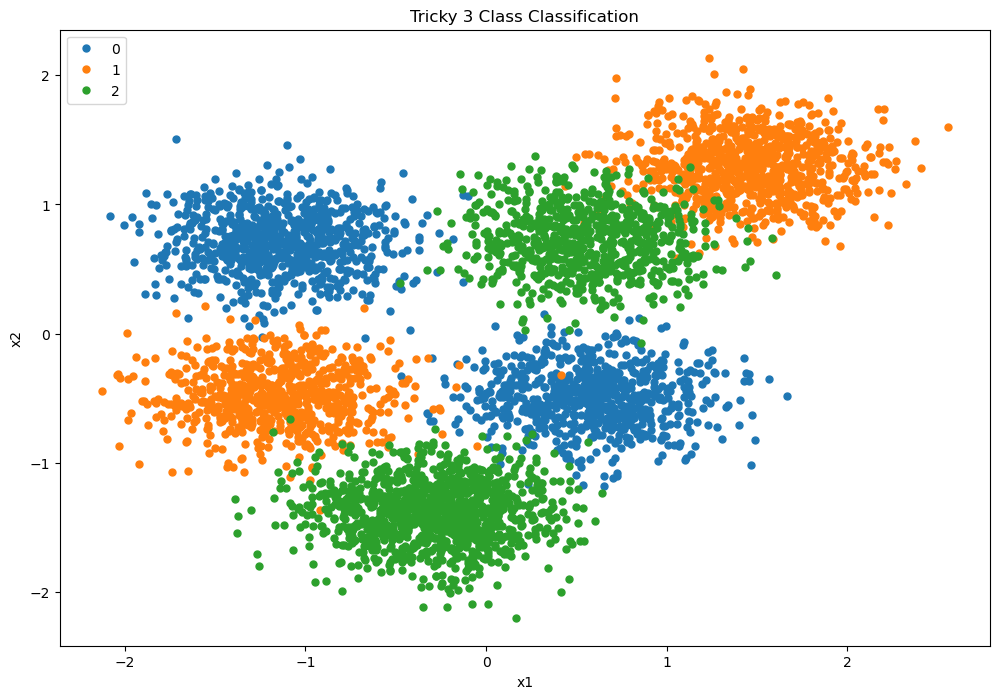

In [5]:
plot_data(X, y)

Build network components from scratch

In [24]:
class Layer:
    def __init__(self):
        self.input_size = None
        self.output_size = None

    def batch_forward(self, input):
        return

    def batch_backward(self, g, learning_rate, lamda, m):
        return

class Input(Layer):
    def __init__(self, size):
        self.layer_name = "input"
        self.input_size = size
        self.output_size = size
        self.neurons = np.zeros((size))
        self.prev_layer = None
        self.next_layer = None
        self.batch_values = None

    def forward(self, values):
        self.neurons = values
        if self.next_layer != None:
            self.next_layer.forward(self.neurons)

    def batch_forward(self, values):
        self.batch_values = values
        if self.next_layer != None:
            self.next_layer.batch_forward(self.batch_values)

class Linear(Layer):
    def __init__(self, size):
        self.layer_name = "linear"
        self.input_size = None
        self.output_size = size
        self.neurons = np.zeros((self.output_size))
        self.weights = None
        self.bias = np.zeros(self.output_size)
        self.weights_gradient = None
        self.bias_gradient = np.zeros((self.output_size))
        self.prev_layer = None
        self.next_layer = None
        self.batch_values = None

    def initialize_layer(self, prev_layer):
        self.prev_layer = prev_layer
        self.input_size = prev_layer.neurons.shape[0]
        self.weights = np.random.uniform(-1, 1, size=(self.input_size, self.output_size))
        self.weights_gradient = np.zeros((self.input_size, self.output_size))

    def batch_forward(self, values):
        self.batch_values = np.dot(values, self.weights) + self.bias
        if self.next_layer != None:
            self.next_layer.batch_forward(self.batch_values)

    def batch_backward(self, g, learning_rate, lamda, m):
        self.bias_gradient = np.sum(g, axis=0)
        self.weights_gradient = np.dot(np.transpose(self.prev_layer.batch_values), g)
        self.bias = self.bias - (learning_rate * self.bias_gradient)/len(self.batch_values)
        
        # subtracting regularization derivative
        self.weights = np.maximum(0, self.weights - (learning_rate * lamda) * self.weights / (2 * m))
        
        self.weights = self.weights - (learning_rate * self.weights_gradient) / len(self.batch_values)
        g = np.dot(g, np.transpose(self.weights))
        if self.prev_layer != None:
            self.prev_layer.batch_backward(g, learning_rate, lamda, m)

class Relu(Layer):
    def __init__(self, size):
        self.layer_name = "relu"
        self.input_size = None
        self.output_size = size
        self.neurons = np.zeros((self.output_size))
        self.prev_layer = None
        self.next_layer = None
        self.batch_values = None

    def initialize_layer(self, prev_layer):
        self.prev_layer = prev_layer
        self.input_size = prev_layer.neurons.shape[0]

    def relu_derivative(self, x):
        if x > 0:
            return 1
        else:
            return 0

    def batch_forward(self, values):
        self.batch_values = np.maximum(0, values)
        if self.next_layer != None:
            self.next_layer.batch_forward(self.batch_values)

    def batch_backward(self, g, learning_rate, lamda, m):
        vec_relu_derivative = np.vectorize(self.relu_derivative)
        g = np.multiply(g, vec_relu_derivative(self.batch_values))
        if self.prev_layer != None:
            self.prev_layer.batch_backward(g, learning_rate, lamda, m)
    
class CrossEntropy():
    def loss(self, Y, Z):
        Z = np.maximum(0.00001, Z)
        loss = np.sum(np.sum(np.multiply(Y, -np.log(Z)), axis=1))
        return loss
    
    def gradient(self, Y, Z):
        gradient = Z - Y
        gradient /= len(Y)
        return gradient
    
class SoftMax(Layer):
    def __init__(self, size):
        self.layer_name = "softmax"
        self.input_size = None
        self.output_size = size
        self.neurons = np.zeros((self.output_size))
        self.prev_layer = None
        self.next_layer = None
        self.batch_values = None

    def initialize_layer(self, prev_layer):
        self.prev_layer = prev_layer
        self.input_size = prev_layer.neurons.shape[0]

    def batch_forward(self, scores):
        exp_scores = np.exp(scores)

        # Softmax activation
        self.batch_values = exp_scores/np.sum(exp_scores, axis=1, keepdims=True)
        
        if self.next_layer != None:
            self.next_layer.batch_forward(self.batch_values)

    def batch_backward(self, g, learning_rate, lamda, m):
        if self.prev_layer != None:
            self.prev_layer.batch_backward(g, learning_rate, lamda, m)

class MLP():
    def __init__(self):
        self.input_layer = None
        self.last_layer = None

    def add(self, layer):
        if self.input_layer == None:
            self.input_layer = layer
            self.last_layer = layer
        else:
            layer.initialize_layer(self.last_layer)
            self.last_layer.next_layer = layer
            self.last_layer = layer

    def batch_forward(self, values):
        self.input_layer.batch_forward(values)

    def batch_backward(self, Y, learning_rate, lamda, m):
        g = self.loss_fn.gradient(Y, self.last_layer.batch_values)
        self.last_layer.batch_backward(g, learning_rate, lamda, m)
    
    def compile(self, validation=False):
        self.loss_fn = CrossEntropy()
        self.validation = validation
        
    def l2_norm(self):
        l2 = 0
        curr_layer = self.last_layer
        while curr_layer != None:
            if curr_layer.layer_name == "linear":
                l2 += np.linalg.norm(curr_layer.weights, ord='fro')**2
            curr_layer = curr_layer.prev_layer
        return l2

    def train(self, train, num_features, epochs, minibatch_size, learning_rate, lamda=0):
        loss_values = []
        prev_validation_accuracy = 0
        
        if self.validation == True:
            train_size = int(0.8 * len(train))
            validation = train[train_size:, :]
            train = train[:train_size, :]
            validation_x, validation_y = validation[:, :num_features], validation[:, num_features:]
        
        for epoch in range(epochs):
            np.random.shuffle(train)
            data = train[:, :num_features]
            labels = train[:, num_features:]
            start_index = 0
            end_index = minibatch_size
            m = len(train)
            l = 0
            while end_index <= len(data):
                batch_x = data[start_index:end_index]
                batch_y = labels[start_index:end_index]
                self.batch_forward(batch_x)
                l = l + self.loss_fn.loss(batch_y, self.last_layer.batch_values)
                self.batch_backward(batch_y, learning_rate, lamda, m)
                start_index = end_index
                end_index = end_index + minibatch_size
            loss = l / len(train) + lamda * self.l2_norm() / (2 * m)
            loss_values.append(loss)
            
            if self.validation:
                acc = self.evaluate(validation_x, validation_y)
                if acc > 0.9 and acc < prev_validation_accuracy + 0.001:
                    print("Epoch: ", epoch + 1, "Loss: ", loss)
                    return loss_values
                else:
                    prev_validation_accuracy = acc
                
            if (epoch + 1) % 100 == 0:
                print("Epoch: ", epoch + 1, "Loss: ", loss)
        return loss_values
    
    def evaluate(self, test_x, test_y):
        # make predictions on test data
        predictions = []
        for x in test_x:
            self.batch_forward([x])
            predictions.append(self.last_layer.batch_values[0])
            
        # compute accuracy
        total, error = len(predictions), 0
        for index, res in enumerate(predictions):
            y_hat = np.argmax(res)
            y = np.argmax(test_y[index])
            if y_hat != y:
                error += 1
        accuracy = (total - error)/total
        return accuracy

Helper functions

In [7]:
# helper functions
def plot_loss(epochs, loss):
    # Loss plot for training
    plt.plot(range(1, epochs + 1), loss)
    plt.title("Train Loss Plot")
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.show()
    
def plot_decision_boundary(model):
    x1 = np.linspace(-2, 2, num = 100)
    x2 = np.linspace(-2, 2, num = 100)

    class0_x1, class0_x2, class1_x1, class1_x2, class2_x1, class2_x2 = [], [], [], [], [], []

    # make predictions on test data
    for f1 in x1:
        for f2 in x2:
            x = [f1, f2]
            model.batch_forward([x])
            prediction = model.last_layer.batch_values[0]
            y = np.argmax(prediction)
            if y == 0:
                class0_x1.append(f1)
                class0_x2.append(f2)
            elif y == 1:
                class1_x1.append(f1)
                class1_x2.append(f2)
            else:
                class2_x1.append(f1)
                class2_x2.append(f2)

    plt.title("Plotting Decision Boundary")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.scatter(class0_x1, class0_x2, label="Class 0")
    plt.scatter(class1_x1, class1_x2, label="Class 1")
    plt.scatter(class2_x1, class2_x2, label="Class 2")
    plt.legend()
    plt.show()
    
def print_accuracy(model, test_x, test_y):
    # Test Accuracy
    accuracy = model.evaluate(test_x, test_y)
    print("Test Accuracy: ", accuracy)

Split data into test and train

In [8]:
data["class_0"] = pd.DataFrame([1 if element == 0 else 0 for element in data["y"].values])
data["class_1"] = pd.DataFrame([1 if element == 1 else 0 for element in data["y"].values])
data["class_2"] = pd.DataFrame([1 if element == 2 else 0 for element in data["y"].values])
dataset = data[["x1", "x2", "class_0", "class_1", "class_2"]].values

# dataset size
dataset_size = len(dataset)

# train size
train_size = int(0.8 * dataset_size)

# test size
test_size = dataset_size - train_size

# train set
train = dataset[:train_size]
train_x, train_y = train[:, :2], train[:, 2:]

# test set
test_x, test_y = dataset[train_size:, :2], dataset[train_size:, 2:]

Multi-Layer Perceptron Network

Epoch:  100 Loss:  0.32060518959023193
Epoch:  200 Loss:  0.22103311034293271
Epoch:  300 Loss:  0.1723936652825119
Epoch:  400 Loss:  0.14495592740158997
Epoch:  500 Loss:  0.12869453238226497


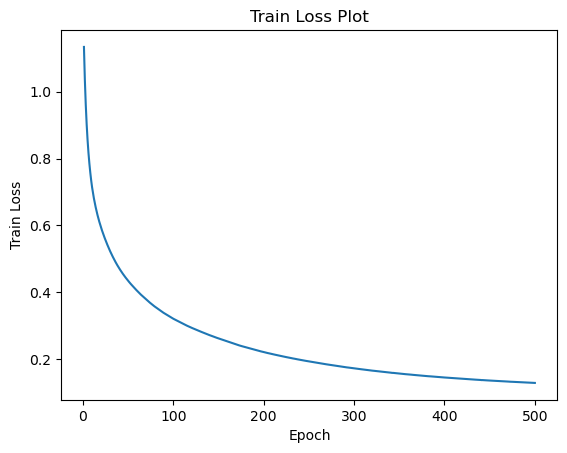

Test Accuracy:  0.969


In [9]:
model = MLP()
model.add(Input(2))
model.add(Linear(128))
model.add(Relu(128))
model.add(Linear(3))
model.add(SoftMax(3))
model.compile()
loss = model.train(train, num_features=2, epochs=500, minibatch_size=10, learning_rate=0.01, lamda=0.01)

# Loss plot for training
plot_loss(len(loss), loss)

# Test Accuracy
print_accuracy(model, test_x, test_y)

Generate the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the three different labels. 

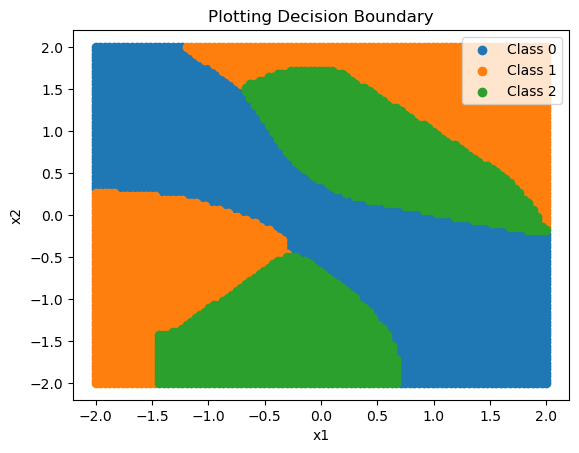

In [10]:
# Plot decision boundary
plot_decision_boundary(model)

Try out different MLP architectures

Epoch:  100 Loss:  0.5510614790097174
Epoch:  200 Loss:  0.32502602422554966
Epoch:  300 Loss:  0.2492564354179797
Epoch:  400 Loss:  0.21502243023618214
Epoch:  500 Loss:  0.19260824652408548
Epoch:  600 Loss:  0.17324794820252362
Epoch:  700 Loss:  0.15569870811666608
Epoch:  800 Loss:  0.14140364701421795
Epoch:  900 Loss:  0.13082293745300766
Epoch:  1000 Loss:  0.12272949848043087


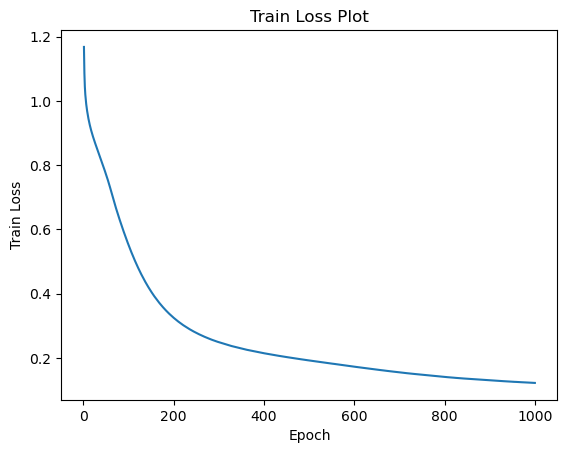

Test Accuracy:  0.958


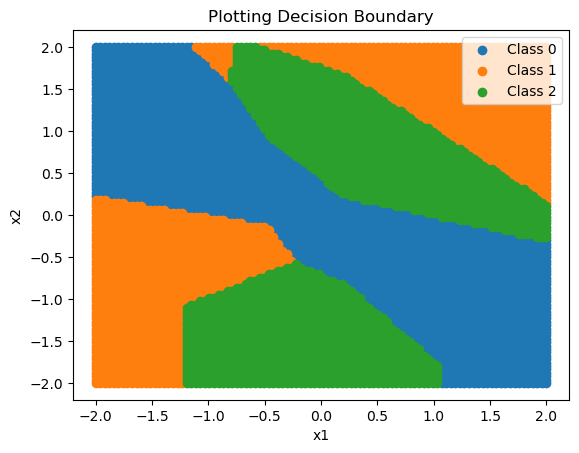

In [9]:
model = MLP()
model.add(Input(2))
model.add(Linear(16))
model.add(Relu(16))
model.add(Linear(3))
model.add(SoftMax(3))
model.compile()
loss = model.train(train, num_features=2, epochs=1000, minibatch_size=10, learning_rate=0.01, lamda=0.01)

# Loss plot for training
plot_loss(len(loss), loss)

# Test Accuracy
print_accuracy(model, test_x, test_y)

# Plot decision boundary
plot_decision_boundary(model)

Epoch:  100 Loss:  0.4388278904966719
Epoch:  200 Loss:  0.2979651175121735
Epoch:  300 Loss:  0.23115425594882746
Epoch:  400 Loss:  0.2067362400297518
Epoch:  500 Loss:  0.18365583881732117
Epoch:  600 Loss:  0.15819844755610646
Epoch:  700 Loss:  0.12917452320814032
Epoch:  800 Loss:  0.11016912659526186
Epoch:  900 Loss:  0.10086123988212575
Epoch:  1000 Loss:  0.0955699160648142


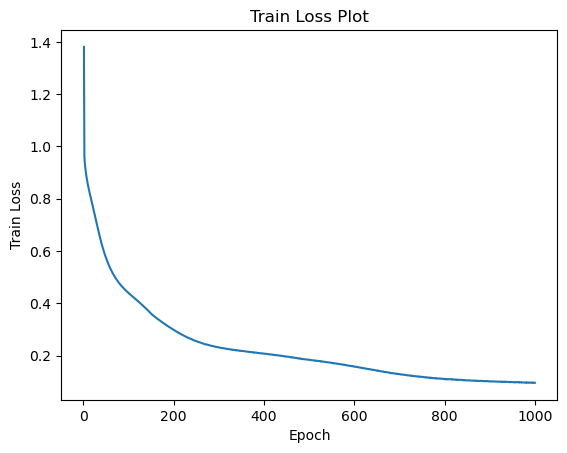

Test Accuracy:  0.976


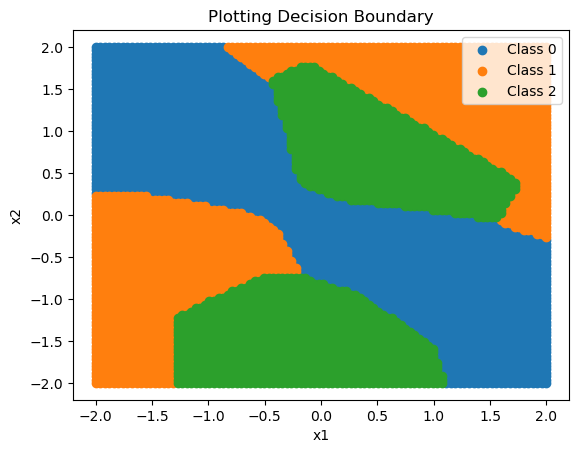

In [24]:
model = MLP()
model.add(Input(2))
model.add(Linear(16))
model.add(Relu(16))
model.add(Linear(8))
model.add(Relu(8))
model.add(Linear(3))
model.add(SoftMax(3))
model.compile()
loss = model.train(train, num_features=2, epochs=1000, minibatch_size=10, learning_rate=0.01, lamda=0.01)

# Loss plot for training
plot_loss(len(loss), loss)

# Test Accuracy
print_accuracy(model, test_x, test_y)

# Plot decision boundary
plot_decision_boundary(model)

Build an MLP network to detect breast cancer

Dataset Link: https://drive.google.com/drive/folders/1TV1kg-QaLTWcZeYYMaXjplPbs6ThxlwQ?usp=sharing

In [48]:
df = pd.read_csv("breast-cancer.csv")

df["label"] = pd.DataFrame([1 if label == "M" else 0 for label in df["diagnosis"].values])
df = df.sample(frac = 1)

radius_mean = np.mean(np.array(df[["radius_mean"]].values))
texture_mean = np.mean(np.array(df[["texture_mean"]].values))
perimeter_mean = np.mean(np.array(df[["perimeter_mean"]].values))
area_mean = np.mean(np.array(df[["area_mean"]].values))
smoothness_mean = np.mean(np.array(df[["smoothness_mean"]].values))
compactness_mean = np.mean(np.array(df[["compactness_mean"]].values))
concavity_mean = np.mean(np.array(df[["concavity_mean"]].values))
concave_points_mean = np.mean(np.array(df[["concave points_mean"]].values))
radius_worst_mean = np.mean(np.array(df[["radius_worst"]].values))
texture_worst_mean = np.mean(np.array(df[["texture_worst"]].values))
perimeter_worst_mean = np.mean(np.array(df[["perimeter_worst"]].values))
area_worst_mean = np.mean(np.array(df[["area_worst"]].values))

df["radius"] = [x / radius_mean for x in df["radius_mean"].values]
df["texture"] = [x / texture_mean for x in df["texture_mean"].values]
df["perimeter"] = [x / perimeter_mean for x in df["perimeter_mean"].values]
df["area"] = [x / area_mean for x in df["area_mean"].values]
df["smoothness"] = [x / smoothness_mean for x in df["smoothness_mean"].values]
df["compactness"] = [x / compactness_mean for x in df["compactness_mean"].values]
df["concavity"] = [x / concavity_mean for x in df["concavity_mean"].values]
df["concave"] = [x / concave_points_mean for x in df["concave points_mean"].values]
df["radius_worst"] = [x / radius_worst_mean for x in df["radius_worst"].values]
df["texture_worst"] = [x / texture_worst_mean for x in df["texture_worst"].values]
df["perimeter_worst"] = [x / perimeter_worst_mean for x in df["perimeter_worst"].values]
df["area_worst"] = [x / area_worst_mean for x in df["area_worst"].values]

arr = []
for element in df["label"].values:
    if element == 0:
        arr.append(1)
    else:
        arr.append(0)
        
df["not_label"] = arr

df = df[["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave", \
         "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "label", "not_label"]]

new_dataset = df.values
new_dataset_size = len(new_dataset)
new_train_size = int(0.8 * new_dataset_size)
new_test_size = new_dataset_size - new_train_size

new_train = new_dataset[:new_train_size, :]
new_test = new_dataset[new_train_size:, :]
new_test_x, new_test_y = new_test[:, :12], new_test[:, 12:]

In [49]:
model = MLP()
model.add(Input(12))
model.add(Linear(16))
model.add(Relu(16))
model.add(Linear(2))
model.add(SoftMax(2))
model.compile(validation=True)
loss = model.train(train=new_train, epochs=600, num_features=12, minibatch_size=10, \
                   learning_rate=0.01, lamda=0.01)

# print accuracy
print_accuracy(model, new_test_x, new_test_y)

Epoch:  38 Loss:  0.47234467028303556
Test Accuracy:  0.9473684210526315


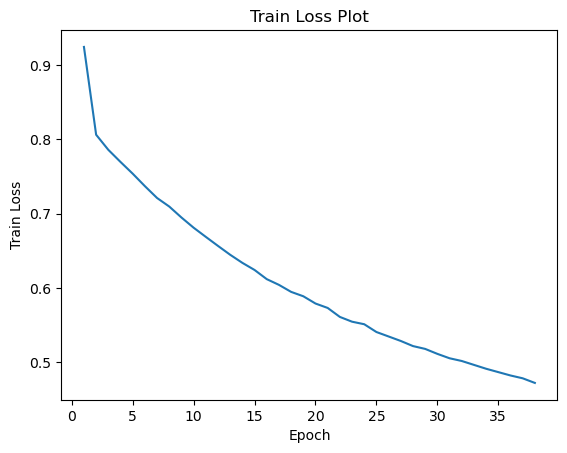

In [50]:
# Loss plot for training
plot_loss(len(loss), loss)

MLP implementation in PyTorch

Epoch 1 Train Loss: 0.7917216420173645
Epoch 2 Train Loss: 0.5179084539413452
Epoch 3 Train Loss: 0.3543645143508911
Epoch 4 Train Loss: 0.2751321494579315
Epoch 5 Train Loss: 0.23130425810813904
Epoch 6 Train Loss: 0.2040192186832428
Epoch 7 Train Loss: 0.1856476217508316
Epoch 8 Train Loss: 0.17257900536060333
Epoch 9 Train Loss: 0.16288207471370697
Epoch 10 Train Loss: 0.15555819869041443
Epoch 11 Train Loss: 0.1497824490070343
Epoch 12 Train Loss: 0.14514026045799255
Epoch 13 Train Loss: 0.14131130278110504
Epoch 14 Train Loss: 0.13811874389648438
Epoch 15 Train Loss: 0.13535793125629425
Epoch 16 Train Loss: 0.1329149305820465
Epoch 17 Train Loss: 0.1307348906993866
Epoch 18 Train Loss: 0.1287599802017212
Epoch 19 Train Loss: 0.1269584596157074
Epoch 20 Train Loss: 0.12529565393924713

Test Accuracy: 0.9610000252723694


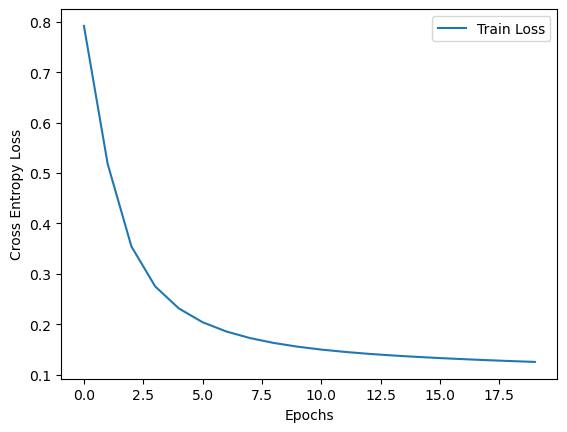

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim

x_train = torch.tensor(train_x, dtype=torch.float32)
y_train = torch.tensor(train_y, dtype=torch.float32)
x_test = torch.tensor(test_x, dtype=torch.float32)
y_test = torch.tensor(test_y, dtype=torch.float32)

class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 8)
        self.act = nn.ReLU()
        self.output = nn.Linear(8, 3)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

# model
model = Multiclass()

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training parameters
epochs = 20
batch_size = 5
batches_per_epoch = len(x_train) // batch_size

loss_hist = []

# training loop
for epoch in range(epochs):
    # set model in training mode
    model.train()
    for i in range(batches_per_epoch):
        # batch
        start = i * batch_size
        batch_x = x_train[start:start+batch_size]
        batch_y = y_train[start:start+batch_size]
        
        # forward propagation
        y_pred = model(batch_x)
        loss = loss_fn(y_pred, batch_y)
        
        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        
        # update weights
        optimizer.step()

    # set model in evaluation mode
    model.eval()
    y_pred = model(x_train)
    loss = float(loss_fn(y_pred, y_train))
    loss_hist.append(loss)
    print("Epoch", epoch + 1, "Train Loss:", loss)
    
# set model in evaluation mode
model.eval()
y_pred = model(x_test)
test_accuracy = float((torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean())
print("\nTest Accuracy:", test_accuracy)

# Plot the loss and accuracy
plt.plot(loss_hist, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()

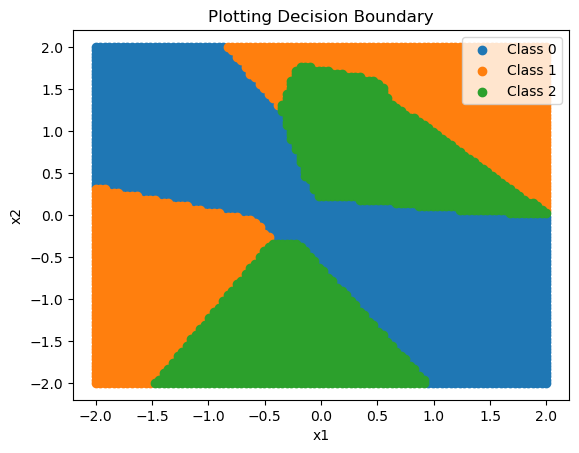

In [52]:
# Plotting decision boundary

x1 = np.linspace(-2, 2, num = 100)
x2 = np.linspace(-2, 2, num = 100)

class0_x1, class0_x2, class1_x1, class1_x2, class2_x1, class2_x2 = [], [], [], [], [], []

# make predictions on data
for f1 in x1:
    for f2 in x2:
        x = torch.tensor([[f1, f2]], dtype=torch.float32)
        # set model in evaluation mode
        model.eval()
        prediction = model(x)
        prediction = prediction.detach().numpy()
        y = np.argmax(np.array(prediction[0]))
        if y == 0:
            class0_x1.append(f1)
            class0_x2.append(f2)
        elif y == 1:
            class1_x1.append(f1)
            class1_x2.append(f2)
        else:
            class2_x1.append(f1)
            class2_x2.append(f2)

plt.title("Plotting Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.scatter(class0_x1, class0_x2, label="Class 0")
plt.scatter(class1_x1, class1_x2, label="Class 1")
plt.scatter(class2_x1, class2_x2, label="Class 2")
plt.legend()
plt.show()